# Introduction to JAX

[JAX](https://jax.readthedocs.io/en/latest/index.html) is an advanced scientific computing library for Python. At a very crude level, it's an alternative to Numpy that provides auto-differentiation and Xcellerated Linear Algebra (XLA) that can run on GPUs and TPUs. Unlike Tensorflow and PyTorch, it only operates within a functional programming paradigm, where all functions must be pure (i.e., enforce referential transparency). It is developed and maintained by Google.

## Imports

In [1]:
from typing import List, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## JAX as Accelerated Numpy

JAX implements the Numpy API and more-often-than-not it can be used as a stand-in replacement.

In [2]:
x = jnp.array([1.0, 2.0, 3.0, 4.0, 5.0])
x

DeviceArray([1., 2., 3., 4., 5.], dtype=float32)

There are, however, a few subtle differences. Firstly, the output is of type `DeviceArray`, which represents an array on a particular device (CPU, GPU, etc.). To convert this back to raw Numpy, use the `to_py` method.

In [3]:
x.to_py()

/Users/alexioannides/Dropbox/work/workspace/python/data-science-and-ml-notebook/.venv_jax/lib/python3.10/site-packages/jax/_src/device_array.py:278: FutureWarning: The .to_py() method on JAX arrays is deprecated. Use np.asarray(...) instead.
  warnings.warn("The .to_py() method on JAX arrays is deprecated. Use "


array([1., 2., 3., 4., 5.], dtype=float32)

To convert this to raw Python, use the `tolist` method.

In [4]:
x.tolist()

[1.0, 2.0, 3.0, 4.0, 5.0]

Secondly, when a JAX function is called, the corresponding operation is dispatched to an accelerator to be computed asynchronously when possible. The returned array is therefore not necessarily ‘filled in’ as soon as the function returns. Thus, if we don’t require the result immediately, the computation won’t block Python execution. If the computation is required - e.g., when using the `block_until_ready` method, converting to a Numpy array or printing a result, then the call to the computation will be blocking. See [Asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#asynchronous-dispatch) in the JAX docs.

In [5]:
y = jnp.dot(x, x).block_until_ready()

Jax functions can also work directly with Numpy arrays and it will copy the data to a `DeviceArray` automatically.

In [6]:
x_np = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
jnp.dot(x_np, x_np).block_until_ready()

DeviceArray(55., dtype=float32)

### Immutability

Unlike a Numpy array, is isn't possible to mutate an element in a Jax array as it enforces all of the contraints required by functional programming. Jax does, however, allow you to create new arrays from an in intial array, but with the required elements changed as required.

In [7]:
z = jnp.array([1.0, 2.0, 3.0])
q = z.at[1].set(-2.0)
q

DeviceArray([ 1., -2.,  3.], dtype=float32)

## Random Numbers and Automatic Vectorisation

Using the function tracing techniques exploited by Jax'x [Just-in-Time (JIT) compiler](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html), Jax can also automatically vectorise a function, as we will demonstrate below. We start by creating a function that we will want to vectorise.

Note the application of random number generation in Jax, which is a [departure from NumPy](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html). This requires us to provide a unique 'key' to a RNG algorithm to explicitly manage the state of the RNG (NumPy manages this automatically based on a single seed).

In [8]:
def mean_projection(x: jnp.DeviceArray, n: int = 100) -> jnp.DeviceArray:
    """Compute the mean dot product between x and a random vector."""
    rng_keys = jax.random.split(jax.random.PRNGKey(42), n)
    projections = jnp.array(
        [jnp.dot(x, jax.random.uniform(key, x.shape)) for key in rng_keys]
    )
    return jnp.mean(projections)


mean_projection(x)

DeviceArray(7.5951915, dtype=float32)

We can vectorise this function using Jax's `vmap` function.

In [9]:
mean_projection_vect = jax.vmap(mean_projection)

xs = jnp.stack([x, x, x])
mean_projection_vect(xs)

DeviceArray([7.5951915, 7.5951915, 7.5951915], dtype=float32)

Note, that if we wanted to distribute the vectorisation across devices (e.g., GPU and/or TPU cores), then we would use the `pmap` function instead of `vmap`.

## Mapping over Ragged Collections with `pytrees`

Jax will allow you to map a function over an arbitariilty nested set of collections.

In [10]:
params = {"foo": [1.0, 2, 3, ("2", "3")], "bar": {"1": [2.0, "3"]}}

jax.tree_map(lambda e: float(e), params)

{'bar': {'1': [2.0, 3.0]}, 'foo': [1.0, 2.0, 3.0, (2.0, 3.0)]}

## Auto-Differentiation

Auto-differentiation is Jax follows a functional programming paradigm. For example, consider the following example from PyTorch,

```python
import torch

x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
x.grad

# tensor(4.)
```

This pattern is imperative and functional. In Jax this would be implemented as follows,

In [11]:
def x_squared(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return x**2


x_squared_dx = jax.grad(x_squared)
x_squared_dx(jnp.array(2.0))

DeviceArray(4., dtype=float32, weak_type=True)

We can easily extrapolate this example to a simple gradient descent problem.

100%|██████████| 50/50 [00:00<00:00, 847.60it/s]

x = 2.00


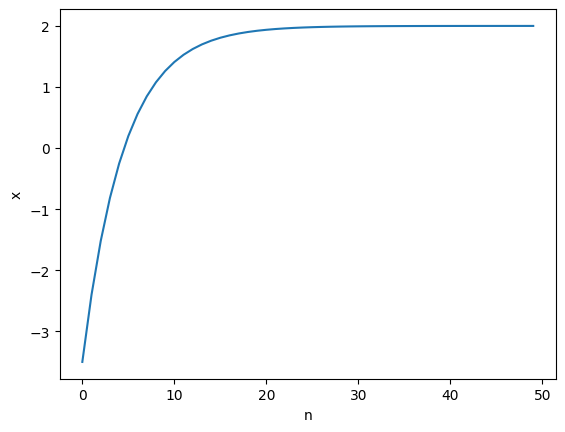

In [12]:
def f(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return (x - 2) ** 2


n_iterations = 50
eta = 0.1

x = jnp.array(-3.5)
x_hist: List[Tuple[int, float]] = []

for n in tqdm(range(n_iterations)):
    x_hist.append((n, x.tolist()))
    x -= eta * jax.grad(f)(x)

print(f"x = {x:.2f}")
_ = sns.lineplot(y="x", x="n", data=pd.DataFrame(x_hist, columns=["n", "x"]))

Which is simpler than the PyTorch equivalent,

```python
def f(x: torch.Tensor) -> torch.Tensor:
    return (x - 2) ** 2


n_iterations = 50
eta = 0.1

x = torch.tensor([-3.5], requires_grad=True)
x_hist: List[Tuple[int, float]] = []

for n in tqdm(range(n_iterations)):
    x_hist.append((n, x.detach().numpy()[0]))
    f(x).backward()
    x.data -= eta * x.grad
    x.grad.zero_()

print(f"x = {x.detach().numpy()[0]:.2f}")
_ = sns.lineplot(
    y="x", x="n", data=pd.DataFrame(x_hist, columns=["n", "x"])
)
```

Because PyTorch needs to handle state (of a function and its gradients).

We can extended this to more complex vector-valued functions, where the `grad` operator will behave like the [$\nabla$ operator](https://en.wikipedia.org/wiki/Del) in formal calculus.

In [13]:
def sum_of_squares(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return jnp.sum(x**2)


sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.array([1.0, 2.0, 3.0, 4.0, 5.0])
print(f"sum-of-squares = {sum_of_squares(x)}")
print(f"d sum-of-squares / dx = {sum_of_squares_dx(x)}")

sum-of-squares = 55.0
d sum-of-squares / dx = [ 2.  4.  6.  8. 10.]


By default, the `grad` operator will only compute derivatives relative to a function's first argument. To extend this to other arguments we use `argnums`.

In [14]:
def sum_of_squared_errors(x: jnp.DeviceArray, y: jnp.DeviceArray) -> jnp.DeviceArray:
    return jnp.sum((x - y) ** 2)


sum_of_squared_errors_dx = jax.grad(sum_of_squared_errors, argnums=(0, 1))

x = jnp.array([1.0, 2.0, 3.0, 4.0, 5.0])
print(f"sum-of-squared-errors = {sum_of_squared_errors(x, x*1.1)}")
print(f"d sum-of-squared-errors / dx = {sum_of_squared_errors_dx(x, x*1.1)[0]}")
print(f"d sum-of-squared-errors / dy = {sum_of_squared_errors_dx(x, x*1.1)[1]}")

sum-of-squared-errors = 0.5500001907348633
d sum-of-squared-errors / dx = [-0.20000005 -0.4000001  -0.6000004  -0.8000002  -1.        ]
d sum-of-squared-errors / dy = [0.20000005 0.4000001  0.6000004  0.8000002  1.        ]


The `grad` function is also enabled to allow us to return a tuple with non-derivative values, via the `has_aux` argument, and there is also a `value_and_grad` alternative to `grad` that return the function value as well as the derivates.